# Valve Voltage Optimizer

This notebook implements a regression model to map valve position + water level → generated voltage, along with a rule-based optimizer to maintain optimal voltage without draining the tank.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


## 1. Load and Prepare Dataset

In [5]:
# Load dataset
df = pd.read_csv('dataset.csv')
df.head()

,valve_position_percent,water_level_cm,water_level_percent,historical_rainfall_mm,generated_voltage_v,generated_power_w
0,0,45,22.5,0.0,0.00,0.00
1,5,47,23.5,0.2,1.85,2.31
2,10,52,26.0,0.5,3.92,7.84
3,15,58,29.0,0.8,6.15,18.45
4,20,65,32.5,1.2,8.52,34.08


In [6]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   valve_position_percent  212 non-null    int64  
 1   water_level_cm          212 non-null    int64  
 2   water_level_percent     212 non-null    float64
 3   historical_rainfall_mm  212 non-null    float64
 4   generated_voltage_v     212 non-null    float64
 5   generated_power_w       212 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 10.1 KB


## 2. Exploratory Data Analysist

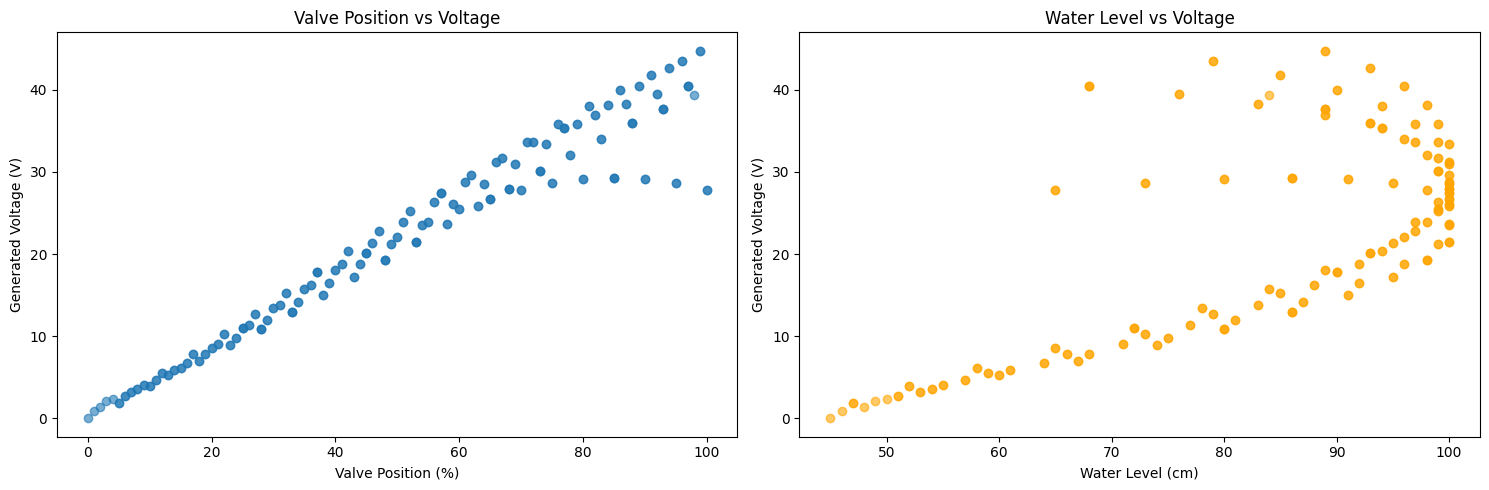

In [41]:
# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Valve position vs voltage
axes[0].scatter(df['valve_position_percent'], df['generated_voltage_v'], alpha=0.6)
axes[0].set_xlabel('Valve Position (%)')
axes[0].set_ylabel('Generated Voltage (V)')
axes[0].set_title('Valve Position vs Voltage')

# Water level vs voltage
axes[1].scatter(df['water_level_cm'], df['generated_voltage_v'], alpha=0.6, color='orange')
axes[1].set_xlabel('Water Level (cm)')
axes[1].set_ylabel('Generated Voltage (V)')
axes[1].set_title('Water Level vs Voltage')

plt.tight_layout()
plt.show()

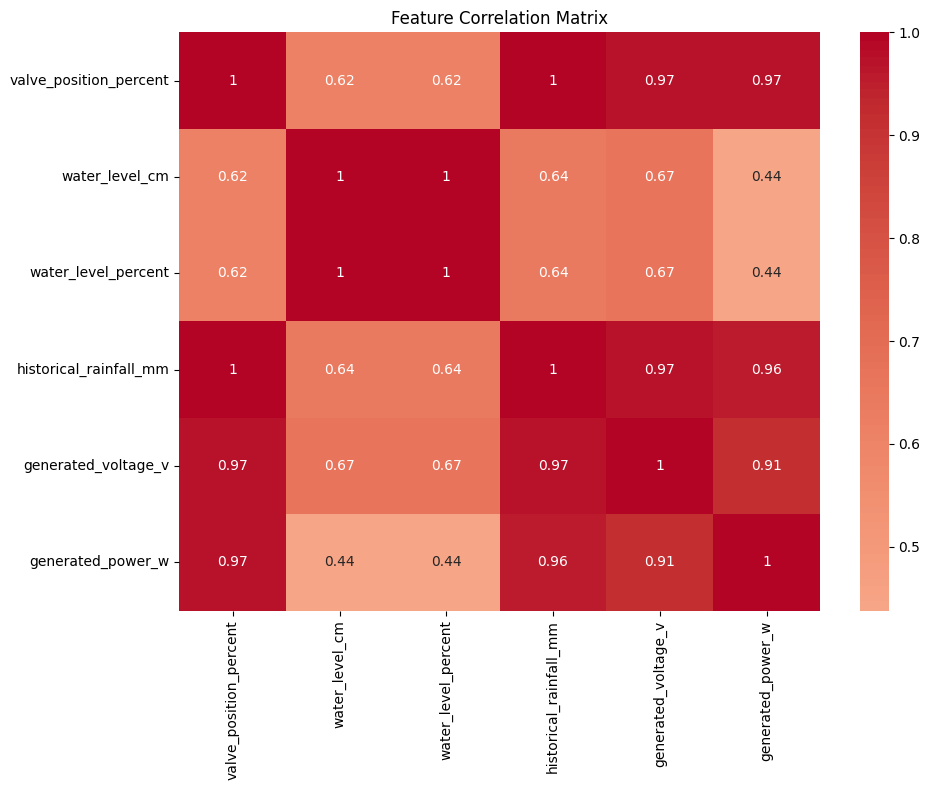

In [42]:
# See correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Preprocessing Data

In [53]:
# Prepare features and target
X = df[['valve_position_percent', 'water_level_cm']].values
y = df['generated_voltage_v'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, train_size=0.8)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Features shape: (212, 2)
Target shape: (212,)
Training samples: 169
Test samples: 43


## 3. Modelling

In [ ]:
# Try different polynomial degrees
degrees = [2, 3, 4]
best_degree = None
best_score = -np.inf

print("Testing polynomial degrees...")
for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_train)

    model = Ridge(alpha=1.0)
    scores = cross_val_score(model, X_poly, y_train, cv=5, scoring='neg_mean_squared_error')
    
    avg_score = -scores.mean()
    print(f"Degree {degree}: CV RMSE = {np.sqrt(avg_score):.3f}")
    

Testing polynomial degrees...
Degree 2: CV RMSE = 2.473
Degree 3: CV RMSE = 2.640
Degree 4: CV RMSE = 2.612


In [66]:
# Train final model with best degree
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_poly_train, y_train)

# Evaluate model
y_pred_train = model.predict(X_poly_train)
y_pred_test = model.predict(X_poly_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

print(f"Training RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test R²: {test_r2:.3f}")

Training RMSE: 2.106
Test RMSE: 3.021
Test R²: 0.917


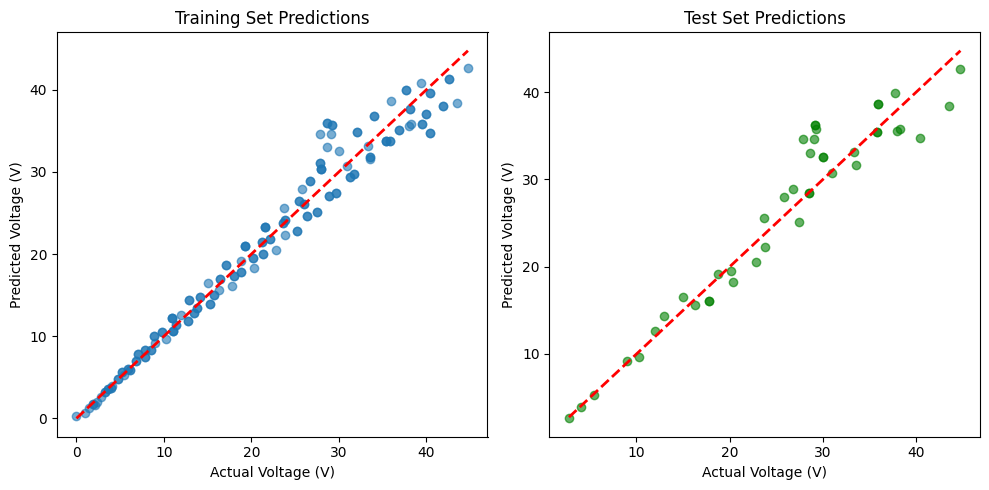

In [54]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Voltage (V)')
plt.ylabel('Predicted Voltage (V)')
plt.title('Training Set Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Voltage (V)')
plt.ylabel('Predicted Voltage (V)')
plt.title('Test Set Predictions')

plt.tight_layout()
plt.show()

## 4. Create Rule-Based Optimizer

In [ ]:
# try valve optimizer
class ValveOptimizer:
    def __init__(self, model, poly):
        self.model = model
        self.poly = poly
    
    def predict_voltage(self, valve_position, water_level):
        X_input = np.array([[valve_position, water_level]])
        X_poly = self.poly.transform(X_input)
        return max(0, self.model.predict(X_poly)[0])
    
    def optimize_valve_position(self, current_water_level, min_water_level=45, max_water_level=100, safety_buffer=5):
        min_safe_level = min_water_level + safety_buffer
        valve_positions = np.linspace(0, 100, 201)
        
        best_voltage = -np.inf
        best_valve_position = 0
        
        for valve_pos in valve_positions:
            voltage = self.predict_voltage(valve_pos, current_water_level)
            water_consumption_rate = valve_pos / 100.0 * 0.5
            estimated_new_level = current_water_level - water_consumption_rate
            
            if estimated_new_level >= min_safe_level:
                if voltage > best_voltage:
                    best_voltage = voltage
                    best_valve_position = valve_pos
        
        return {
            'optimal_valve_position': best_valve_position,
            'predicted_voltage': best_voltage,
            'estimated_water_level_after': current_water_level - (best_valve_position/100 * 0.5),
            'safety_status': 'safe' if current_water_level >= min_safe_level else 'low'
        }

In [56]:
# Initialize optimizer
optimizer = ValveOptimizer(model, poly)

## 5. Test Optimizer with Scenarios

In [60]:
# Test scenarios
scenarios = [
    {'water_level': 50, 'description': 'Low water level'},
    {'water_level': 75, 'description': 'Medium water level'},
    {'water_level': 95, 'description': 'High water level'},
    {'water_level': 45, 'description': 'Critical low water level'}
]

print("=== Trying the models ===")
results = []
for scenario in scenarios:
    result = optimizer.optimize_valve_position(scenario['water_level'])
    results.append({**scenario, **result})
    
    print(f"\n{scenario['description']} (Water: {scenario['water_level']}cm)")
    print(f"  Optimal valve position: {result['optimal_valve_position']:.1f}%")
    print(f"  Predicted voltage: {result['predicted_voltage']:.2f}V")
    print(f"  Estimated water level after: {result['estimated_water_level_after']:.1f}cm")
    print(f"  Safety status: {result['safety_status']}")

=== Trying the models ===

Low water level (Water: 50cm)
  Optimal valve position: 0.0%
  Predicted voltage: 1.08V
  Estimated water level after: 50.0cm
  Safety status: safe

Medium water level (Water: 75cm)
  Optimal valve position: 100.0%
  Predicted voltage: 38.60V
  Estimated water level after: 74.5cm
  Safety status: safe

High water level (Water: 95cm)
  Optimal valve position: 100.0%
  Predicted voltage: 44.63V
  Estimated water level after: 94.5cm
  Safety status: safe

Critical low water level (Water: 45cm)
  Optimal valve position: 0.0%
  Predicted voltage: -infV
  Estimated water level after: 45.0cm
  Safety status: low


## 6. Visualize Results

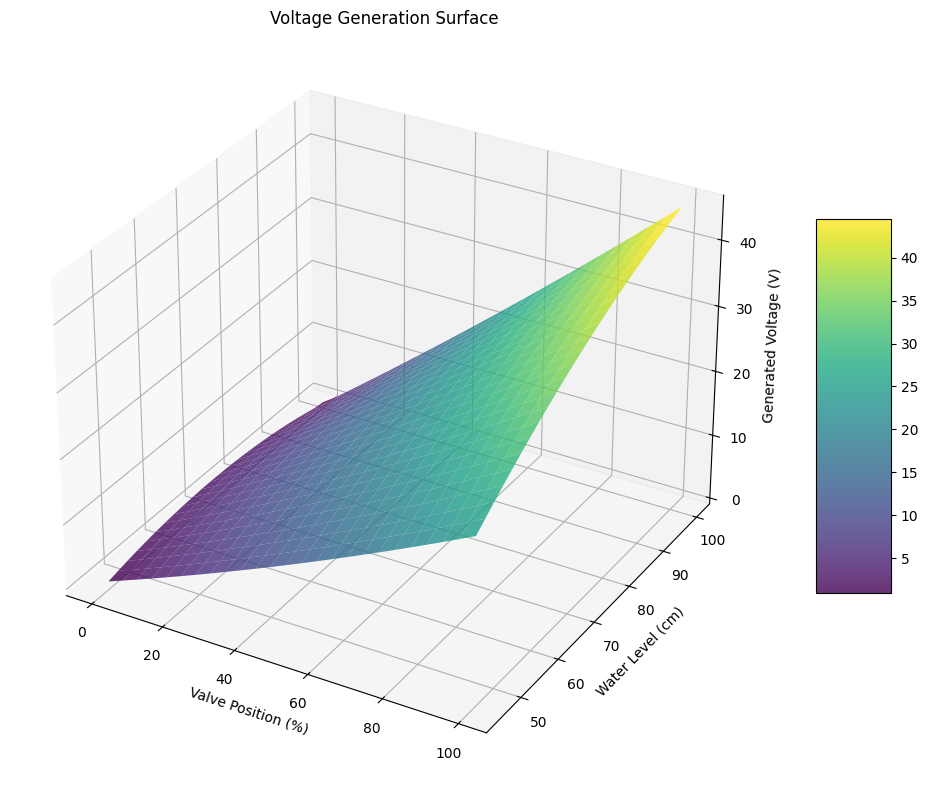

In [49]:
# Create optimization surface plot
water_levels = np.linspace(45, 100, 25)
valve_positions = np.linspace(0, 100, 25)

W, V = np.meshgrid(water_levels, valve_positions)
Z = np.zeros_like(W)

for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        Z[i, j] = optimizer.predict_voltage(V[i, j], W[i, j])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(V, W, Z, cmap='viridis', alpha=0.8)

ax.set_xlabel('Valve Position (%)')
ax.set_ylabel('Water Level (cm)')
ax.set_zlabel('Generated Voltage (V)')
ax.set_title('Voltage Generation Surface')

# Add colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

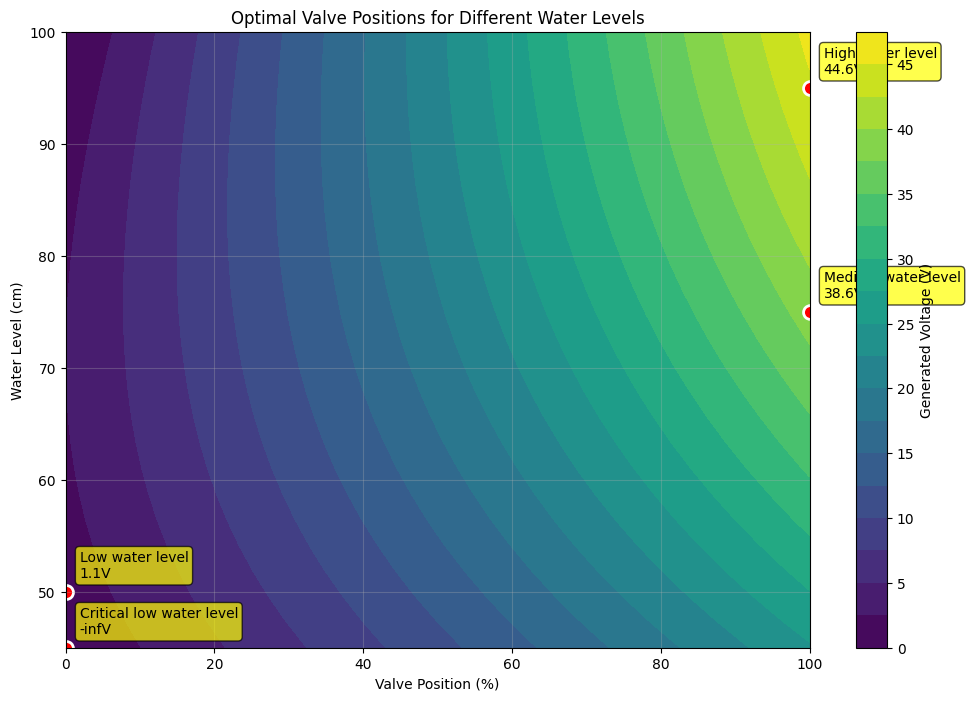

In [50]:
# Create 2D contour plot
plt.figure(figsize=(12, 8))

contour = plt.contourf(V, W, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Generated Voltage (V)')

# Add optimal points from scenarios
for result in results:
    plt.scatter(result['optimal_valve_position'], result['water_level'], 
               color='red', s=100, marker='o', edgecolor='white', linewidth=2)
    plt.annotate(f"{result['description']}\n{result['predicted_voltage']:.1f}V",
                xy=(result['optimal_valve_position'], result['water_level']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.xlabel('Valve Position (%)')
plt.ylabel('Water Level (cm)')
plt.title('Optimal Valve Positions for Different Water Levels')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Interactive Optimization

In [ ]:
# Interactive optimization function
def optimize_for_water_level(water_level):
    if 45 <= water_level <= 100:
        result = optimizer.optimize_valve_position(water_level)
        print(f"\nWater Level: {water_level}cm")
        print(f"Optimal Valve Position: {result['optimal_valve_position']:.1f}%")
        print(f"Predicted Voltage: {result['predicted_voltage']:.2f}V")
        print(f"Safety Status: {result['safety_status']}")
        return result
    else:
        print("Water level must be between 45-100 cm")
        return None

# Test with different water levels
water_levels_to_test = [48, 60, 75, 85, 95]
for wl in water_levels_to_test:
    optimize_for_water_level(wl)


Water Level: 48cm
Optimal Valve Position: 0.0%
Predicted Voltage: -infV
Safety Status: low

Water Level: 60cm
Optimal Valve Position: 100.0%
Predicted Voltage: 32.38V
Safety Status: safe

Water Level: 75cm
Optimal Valve Position: 100.0%
Predicted Voltage: 38.60V
Safety Status: safe

Water Level: 85cm
Optimal Valve Position: 100.0%
Predicted Voltage: 41.93V
Safety Status: safe

Water Level: 95cm
Optimal Valve Position: 100.0%
Predicted Voltage: 44.63V
Safety Status: safe


<!-- ### How to use this optimizer:

1. **Load your current water level**
2. **Call `optimize_valve_position(water_level)`** to get optimal settings
3. **Monitor water level** and adjust as needed

### Key insights from the analysis:
- Higher water levels generally allow for higher valve positions and better voltage output
- At low water levels, the optimizer reduces valve position to prevent tank drainage
- The relationship between valve position and voltage is non-linear and depends on water level
- Safety buffer ensures sustainable operation -->